In [1]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.cloud import bigquery
client = bigquery.Client.from_service_account_json(
        'GDELT2-c60e8f0ed67d.json')

In [3]:
def get_result_dataframe(query, index_col_name=None, datetime_cols=None):
    query_job = client.query(query)
    print('end loading')
    rows = []
    for row in query_job: 
        rows.append(pd.Series(dict(row.items())))
    df = pd.DataFrame(rows)
    if datetime_cols is not None:
        for datetime_col in datetime_cols:
            df[datetime_col] = pd.to_datetime(df[datetime_col], format='%Y%m%d', errors='ignore')
    if index_col_name is not None:
        df.index = df[index_col_name]
        df.drop([index_col_name], inplace=True, axis=1)
    return(df)

In [4]:
def rank_chart(values, labels, title='',figsize=(15,7)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(values))
    rects = ax1.barh(pos, values,
              align='center',
              height=0.5,
              tick_label=labels)
    ax1.grid(axis='x', linestyle='--')
    ax2 = ax1.twinx()
    ax2.set_yticks(pos)
    ax2.set_ylim(ax1.get_ylim())
    max_width = max(values)
    for rect, label in zip(rects, values):
        width = rect.get_width()
        if rect.get_width() < max_width / 5:
            xloc = 5
            clr = 'black'
            align = 'left'
        else:
            xloc = -5
            clr = 'white'
            align = 'right'
        yloc = rect.get_y() + rect.get_height() / 2
        label = ax1.annotate(label, xy=(width, yloc), xytext=(xloc, 0),
                            textcoords="offset points",
                            ha=align, va='center',
                            color=clr, weight='bold', clip_on=True)
    ax1.set_title(title)
    plt.show()

### Actor1Code/Actor2Code

In [8]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "actor1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Code IS NOT NULL
UNION ALL
SELECT "actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2Code IS NOT NULL
UNION ALL
SELECT "actor1_actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Code IS NOT NULL
AND Actor2Code IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

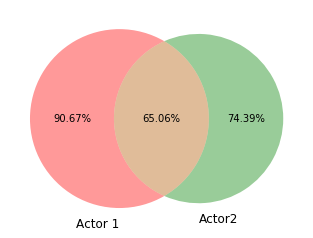

In [14]:
from matplotlib_venn import venn2

data = df.reindex(['actor1', 'actor2', 'actor1_actor2'])['count']
total = df.loc['all']['count'] * 1.
formatter = lambda x: '%.2f'%(x/total * 100.) + '%'
labels = ['Actor 1', 'Actor2']
venn2(subsets=data, set_labels=labels, subset_label_formatter=formatter )
plt.show()

### Actor1Name/Actor2Name

In [15]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "actor1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Name IS NOT NULL
UNION ALL
SELECT "actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2Name IS NOT NULL
UNION ALL
SELECT "actor1_actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Name IS NOT NULL
AND Actor2Name IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

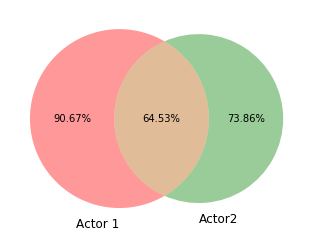

In [16]:
from matplotlib_venn import venn2

data = df.reindex(['actor1', 'actor2', 'actor1_actor2'])['count']
total = df.loc['all']['count'] * 1.
formatter = lambda x: '%.2f'%(x/total * 100.) + '%'
labels = ['Actor 1', 'Actor2']
venn2(subsets=data, set_labels=labels, subset_label_formatter=formatter )
plt.show()

### Actor1CountryCode/Actor2CountryCode

In [17]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "actor1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1CountryCode IS NOT NULL
UNION ALL
SELECT "actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2CountryCode IS NOT NULL
UNION ALL
SELECT "actor1_actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2CountryCode IS NOT NULL
AND Actor1CountryCode IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

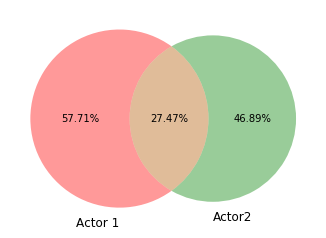

In [18]:
from matplotlib_venn import venn2

data = df.reindex(['actor1', 'actor2', 'actor1_actor2'])['count']
total = df.loc['all']['count'] * 1.
formatter = lambda x: '%.2f'%(x/total * 100.) + '%'
labels = ['Actor 1', 'Actor2']
venn2(subsets=data, set_labels=labels, subset_label_formatter=formatter )
plt.show()

In [19]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "actor1_eq_actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1CountryCode = Actor2CountryCode
UNION ALL
SELECT "actor1_actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2CountryCode IS NOT NULL
AND Actor1CountryCode IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

In [24]:
df = df['count']
print(round(100.0 * df.loc['actor1_eq_actor2'] / df.loc['actor1_actor2'], 2))

24.68


In [28]:
query = """
SELECT Actor1CountryCode as country, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1CountryCode IS NOT NULL
GROUP BY Actor1CountryCode
ORDER BY count DESC
LIMIT 10
"""
df = get_result_dataframe(query)

In [34]:
cameo_country_codes = pd.read_csv('CAMEO.country.csv', sep='\t', dtype='str')
cameo_country_mapping = cameo_country_codes.groupby('CODE')['LABEL'].first()
df['name'] = df['country'].map(cameo_country_mapping)
df = df[::-1]

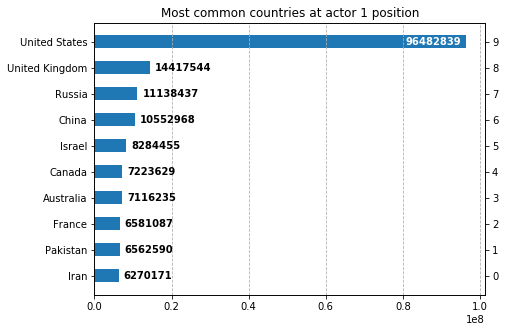

In [41]:
rank_chart(df['count'], df['name'], 'Most common countries at actor 1 position', figsize=(7,5))

In [43]:
query = """
SELECT Actor2CountryCode as country, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2CountryCode IS NOT NULL
GROUP BY Actor2CountryCode
ORDER BY count DESC
LIMIT 10
"""
df = get_result_dataframe(query)

In [44]:
df['name'] = df['country'].map(cameo_country_mapping)
df = df[::-1]

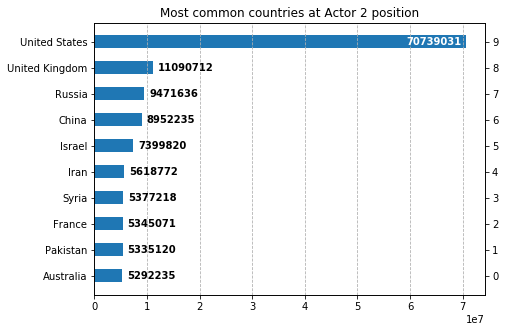

In [45]:
rank_chart(df['count'], df['name'], 'Most common countries at Actor 2 position', figsize=(7,5))

### Actor1KnownGroupCode/Actor2KnownGroupCode

In [66]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "actor1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1KnownGroupCode IS NOT NULL
UNION ALL
SELECT "actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2KnownGroupCode IS NOT NULL
UNION ALL
SELECT "actor1_actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1KnownGroupCode IS NOT NULL
AND Actor2KnownGroupCode IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

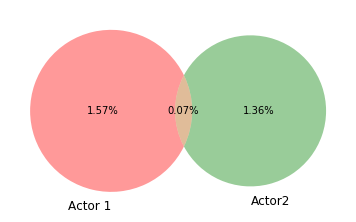

In [67]:
data = df.reindex(['actor1', 'actor2', 'actor1_actor2'])['count']
total = df.loc['all']['count'] * 1.
formatter = lambda x: '%.2f'%(x/total * 100.) + '%'
labels = ['Actor 1', 'Actor2']
venn2(subsets=data, set_labels=labels, subset_label_formatter=formatter )
plt.show()

In [48]:
query = """
SELECT Actor1KnownGroupCode as group_id, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1KnownGroupCode IS NOT NULL
GROUP BY Actor1KnownGroupCode
ORDER BY count DESC
LIMIT 10
"""
df1 = get_result_dataframe(query)
query = """
SELECT Actor2KnownGroupCode as group_id, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2KnownGroupCode IS NOT NULL
GROUP BY Actor2KnownGroupCode
ORDER BY count DESC
LIMIT 10
"""
df2 = get_result_dataframe(query)

In [85]:
cameo_known_group_mapping = pd.read_csv('CAMEO.knowngroup.csv').groupby('CODE')['LABEL'].first()

In [78]:
df1['name'] = df1['group_id'].map(cameo_known_group_mapping)
df2['name'] = df2['group_id'].map(cameo_known_group_mapping)
df1 = df1[::-1]
df2 = df2[::-1]

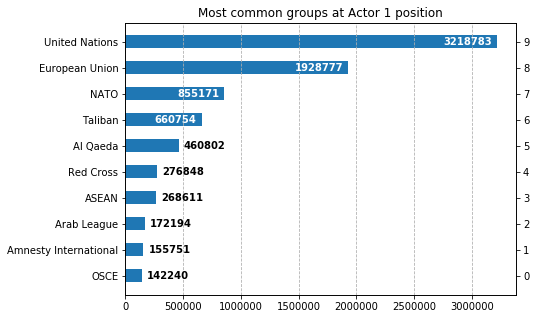

In [79]:
rank_chart(df1['count'], df1['name'], 'Most common groups at Actor 1 position', figsize=(7,5))

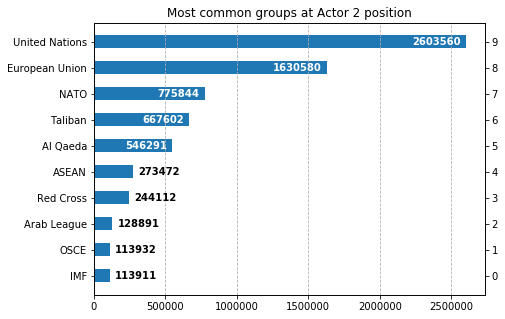

In [80]:
rank_chart(df2['count'], df2['name'], 'Most common groups at Actor 2 position', figsize=(7,5))

### Actor1EthnicCode/Actor2EthnicCode

In [81]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "actor1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1EthnicCode IS NOT NULL
UNION ALL
SELECT "actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2EthnicCode IS NOT NULL
UNION ALL
SELECT "actor1_actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1EthnicCode IS NOT NULL
AND Actor2EthnicCode IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

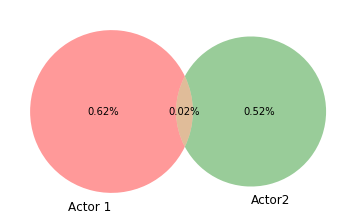

In [82]:
data = df.reindex(['actor1', 'actor2', 'actor1_actor2'])['count']
total = df.loc['all']['count'] * 1.
formatter = lambda x: '%.2f'%(x/total * 100.) + '%'
labels = ['Actor 1', 'Actor2']
venn2(subsets=data, set_labels=labels, subset_label_formatter=formatter )
plt.show()

In [83]:
query = """
SELECT Actor1EthnicCode as group_id, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1EthnicCode IS NOT NULL
GROUP BY Actor1EthnicCode
ORDER BY count DESC
LIMIT 10
"""
df1 = get_result_dataframe(query)
query = """
SELECT Actor2EthnicCode as group_id, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2EthnicCode IS NOT NULL
GROUP BY Actor2EthnicCode
ORDER BY count DESC
LIMIT 10
"""
df2 = get_result_dataframe(query)

In [98]:
cameo_ethnic_mapping = pd.read_csv('CAMEO.ethnic.csv', sep='\t').groupby('CODE')['LABEL'].first()

In [99]:
df1['name'] = df1['group_id'].map(cameo_ethnic_mapping)
df2['name'] = df2['group_id'].map(cameo_ethnic_mapping)
df1 = df1[::-1]
df2 = df2[::-1]

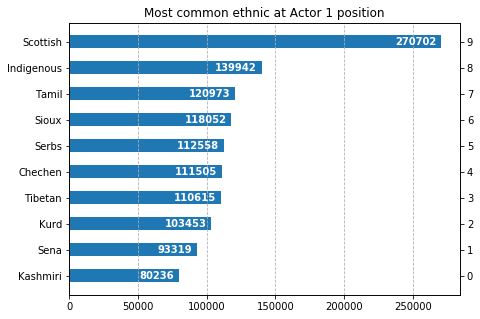

In [102]:
rank_chart(df1['count'], df1['name'], 'Most common ethnic at Actor 1 position', figsize=(7,5))

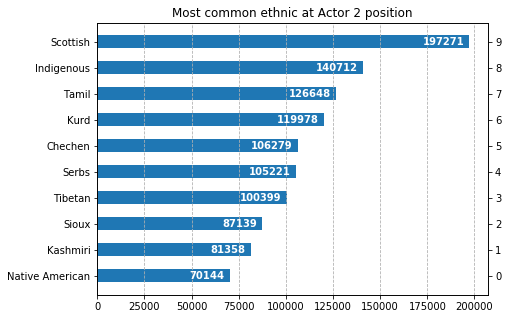

In [103]:
rank_chart(df2['count'], df2['name'], 'Most common ethnic at Actor 2 position', figsize=(7,5))

### Actor1Religion1Code/Actor1Religion2Code/ Actor2Religion1Code/Actor2Religion2Code

In [104]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "actor1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Religion1Code IS NOT NULL
UNION ALL
SELECT "actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2Religion1Code IS NOT NULL
UNION ALL
SELECT "actor1_actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Religion1Code IS NOT NULL
AND Actor2Religion1Code IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

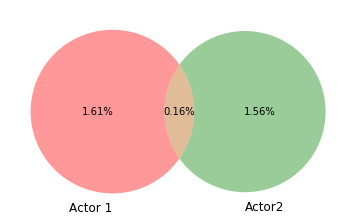

In [105]:
data = df.reindex(['actor1', 'actor2', 'actor1_actor2'])['count']
total = df.loc['all']['count'] * 1.
formatter = lambda x: '%.2f'%(x/total * 100.) + '%'
labels = ['Actor 1', 'Actor2']
venn2(subsets=data, set_labels=labels, subset_label_formatter=formatter )
plt.show()

In [106]:
query = """
SELECT "code1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Religion1Code IS NOT NULL
UNION ALL
SELECT "code2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Religion2Code IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

In [108]:
df = df['count']
print(round(100.0 * df.loc['code2'] / df.loc['code1'], 2))

24.35


In [109]:
query = """
SELECT "code1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2Religion1Code IS NOT NULL
UNION ALL
SELECT "code2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2Religion2Code IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

In [110]:
df = df['count']
print(round(100.0 * df.loc['code2'] / df.loc['code1'], 2))

22.41


In [115]:
query = """
SELECT c1.group_id AS group_id, (c1.count + IFNULL(c2.count,0)) AS count
FROM
    (SELECT Actor1Religion1Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor1Religion1Code IS NOT NULL
    GROUP BY Actor1Religion1Code) AS c1
LEFT JOIN 
    (SELECT Actor1Religion2Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor1Religion2Code IS NOT NULL
    GROUP BY Actor1Religion2Code) AS c2
ON c1.group_id = c2.group_id
ORDER BY count DESC
LIMIT 10
"""
df1 = get_result_dataframe(query)
query = """
SELECT c1.group_id AS group_id, (c1.count + IFNULL(c2.count,0)) AS count
FROM
    (SELECT Actor2Religion1Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor2Religion1Code IS NOT NULL
    GROUP BY Actor2Religion1Code) AS c1
LEFT JOIN 
    (SELECT Actor2Religion2Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor2Religion2Code IS NOT NULL
    GROUP BY Actor2Religion2Code) AS c2
ON c1.group_id = c2.group_id
ORDER BY count DESC
LIMIT 10
"""
df2 = get_result_dataframe(query)

In [132]:
cameo_religion_mapping = pd.read_csv('CAMEO.religion.csv', sep='\t').groupby('CODE')['LABEL'].first()

In [117]:
df1['name'] = df1['group_id'].map(cameo_religion_mapping)
df2['name'] = df2['group_id'].map(cameo_religion_mapping)
df1 = df1[::-1]
df2 = df2[::-1]

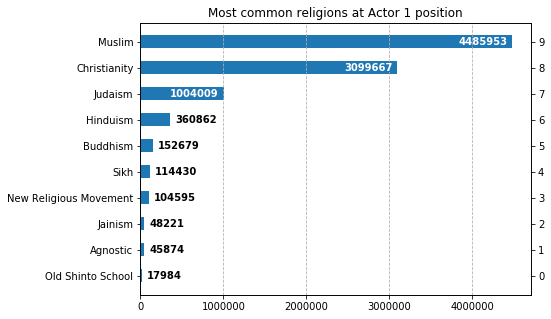

In [119]:
rank_chart(df1['count'], df1['name'], 'Most common religions at Actor 1 position', figsize=(7,5))

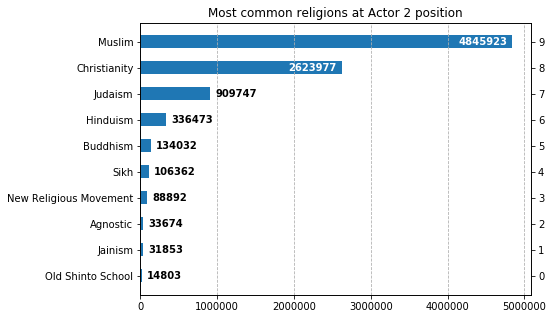

In [120]:
rank_chart(df2['count'], df2['name'], 'Most common religions at Actor 2 position', figsize=(7,5))

### Actor1Type1Code/Actor1Type2Code/Actor1Type3Code/ Actor2Type1Code/Actor2Type2CodeActor2Type3Code/ 

In [121]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "actor1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Type1Code IS NOT NULL
UNION ALL
SELECT "actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2Type1Code IS NOT NULL
UNION ALL
SELECT "actor1_actor2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Type1Code IS NOT NULL
AND Actor2Type1Code IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

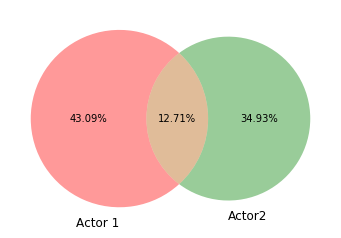

In [122]:
data = df.reindex(['actor1', 'actor2', 'actor1_actor2'])['count']
total = df.loc['all']['count'] * 1.
formatter = lambda x: '%.2f'%(x/total * 100.) + '%'
labels = ['Actor 1', 'Actor2']
venn2(subsets=data, set_labels=labels, subset_label_formatter=formatter )
plt.show()

In [125]:
query = """
SELECT "code1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Type1Code IS NOT NULL
UNION ALL
SELECT "code2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Type2Code IS NOT NULL
UNION ALL
SELECT "code3" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor1Type3Code IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

In [126]:
df = df['count']
print(round(100.0 * df.loc['code2'] / df.loc['code1'], 2))
print(round(100.0 * df.loc['code3'] / df.loc['code1'], 2))

6.96
0.23


In [127]:
query = """
SELECT "code1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2Type1Code IS NOT NULL
UNION ALL
SELECT "code2" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2Type2Code IS NOT NULL
UNION ALL
SELECT "code3" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE Actor2Type3Code IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

In [128]:
df = df['count']
print(round(100.0 * df.loc['code2'] / df.loc['code1'], 2))
print(round(100.0 * df.loc['code3'] / df.loc['code1'], 2))

6.36
0.18


In [129]:
query = """
SELECT c1.group_id AS group_id, (c1.count + IFNULL(c2.count,0) + IFNULL(c3.count,0)) AS count
FROM
    (SELECT Actor1Type1Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor1Type1Code IS NOT NULL
    GROUP BY Actor1Type1Code) AS c1
LEFT JOIN 
    (SELECT Actor1Type2Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor1Type2Code IS NOT NULL
    GROUP BY Actor1Type2Code) AS c2
ON c1.group_id = c2.group_id
LEFT JOIN 
    (SELECT Actor1Type3Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor1Type3Code IS NOT NULL
    GROUP BY Actor1Type3Code) AS c3
ON c1.group_id = c3.group_id
ORDER BY count DESC
LIMIT 10
"""
df1 = get_result_dataframe(query)
query = """
SELECT c1.group_id AS group_id, (c1.count + IFNULL(c2.count,0) + IFNULL(c3.count,0)) AS count
FROM
    (SELECT Actor2Type1Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor2Type1Code IS NOT NULL
    GROUP BY Actor2Type1Code) AS c1
LEFT JOIN 
    (SELECT Actor2Type2Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor2Type2Code IS NOT NULL
    GROUP BY Actor2Type2Code) AS c2
ON c1.group_id = c2.group_id
LEFT JOIN 
    (SELECT Actor2Type3Code as group_id, COUNT(*) AS count
    FROM `gdelt-bq.full.events`
    WHERE Actor2Type3Code IS NOT NULL
    GROUP BY Actor2Type3Code) AS c3
ON c1.group_id = c3.group_id
ORDER BY count DESC
LIMIT 10
"""
df2 = get_result_dataframe(query)

In [131]:
cameo_type_mapping = pd.read_csv('CAMEO.type.csv', sep='\t').groupby('CODE')['LABEL'].first()

In [133]:
df1['name'] = df1['group_id'].map(cameo_type_mapping)
df2['name'] = df2['group_id'].map(cameo_type_mapping)
df1 = df1[::-1]
df2 = df2[::-1]

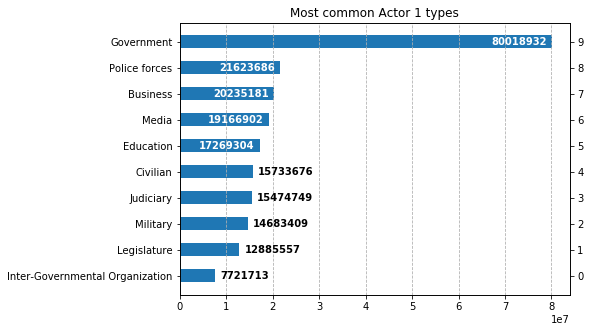

In [134]:
rank_chart(df1['count'], df1['name'], 'Most common Actor 1 types', figsize=(7,5))

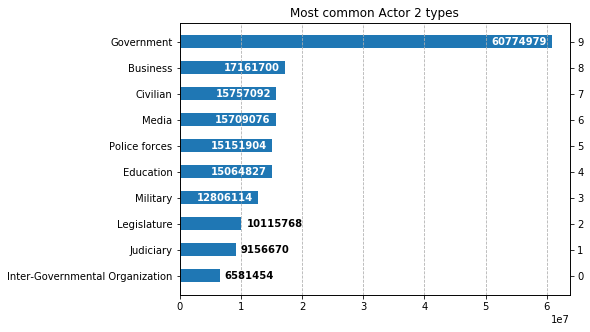

In [135]:
rank_chart(df2['count'], df2['name'], 'Most common Actor 2 types', figsize=(7,5))

### IsRootEvent

In [136]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "not null" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE IsRootEvent IS NOT NULL
UNION ALL
SELECT "count 1" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE IsRootEvent = 1
UNION ALL
SELECT "count 0" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE IsRootEvent = 0
"""
df = get_result_dataframe(query, index_col_name='cat')

In [138]:
print(round(100.0 * df.loc['not null'] / df.loc['all'], 2))
print(round(100.0 * df.loc['count 1'] / df.loc['not null'], 2))
print(round(100.0 * df.loc['count 0'] / df.loc['not null'], 2))

100.0
63.89
36.11


### EventCode

In [139]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "not null" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE EventCode IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='cat')

In [141]:
print(round(100.0 * df.loc['not null'] / df.loc['all'], 2))

100.0


In [185]:
query = """
SELECT EventRootCode AS code, COUNT(*) AS count
FROM `gdelt-bq.full.events`
GROUP BY EventRootCode
ORDER BY count DESC
"""
df = get_result_dataframe(query, index_col_name='code')

In [186]:
df['part'] = df['count'] / df['count'].sum() * 100.

In [188]:
df.loc['OTHER'] = df[df['part'] < 1.5].sum()
df = df[df['part'] >= 1.5]

In [164]:
cameo_event_mapping = pd.read_csv('CAMEO.eventcodes.csv', sep='\t', dtype='str').groupby('CAMEOEVENTCODE')['EVENTDESCRIPTION'].first()

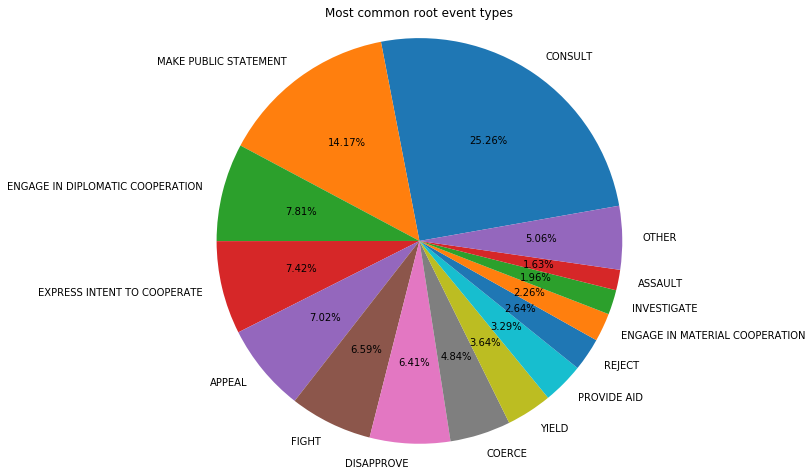

In [193]:
labels = pd.Series(df.index).map(cameo_event_mapping)
labels.loc[labels.isna()] = 'OTHER'
sizes = df['part']

fig, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=10)
ax1.axis('equal')
ax1.set_title('Most common root event types')

plt.show()

### Quad Class

In [194]:
query = """
SELECT QuadClass AS code, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE QuadClass IS NOT NULL
GROUP BY QuadClass
ORDER BY count DESC
"""
df = get_result_dataframe(query, index_col_name='code')

In [196]:
df['part'] = df['count'] / df['count'].sum() * 100.

In [195]:
quad_class_mapping = pd.Series(
    ['Verbal Cooperation', 'Material Cooperation', 'Verbal Conflict', 'Material Conflict'],
    index=[1,2,3,4]
)

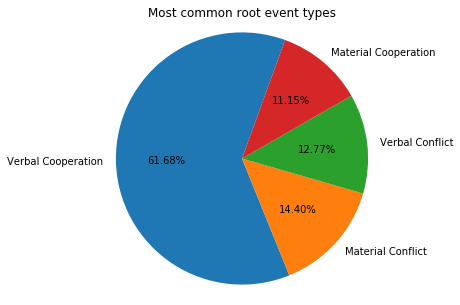

In [203]:
labels = pd.Series(df.index).map(quad_class_mapping)
sizes = df['part']
fig, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=70)
ax1.axis('equal')
ax1.set_title('Most common root event types')

plt.show()

### Goldstain scale

In [209]:
query = """
SELECT GoldsteinScale AS val, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE QuadClass IS NOT NULL
GROUP BY GoldsteinScale
"""
df = get_result_dataframe(query)

In [212]:
df['x'] = np.ceil(df.val)

In [217]:
counts = df.groupby('x')['count'].sum().reindex(np.arange(-10, 11)).fillna(0.0)

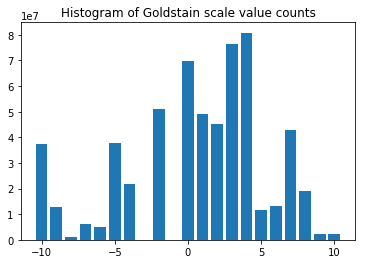

In [220]:
plt.bar(counts.index, height=counts)
plt.title('Histogram of Goldstain scale value counts')
plt.show()

### NumMentions

In [244]:
query = """
WITH maxMentions AS (SELECT MAX(NumMentions) as max_mentions FROM `gdelt-bq.full.events`)
SELECT CEILING(NumMentions / (max_mentions / 50)) * CEILING((max_mentions / 50)) AS val, COUNT(*) AS count
FROM `gdelt-bq.full.events`
LEFT JOIN maxMentions ON TRUE
GROUP BY val
ORDER BY val
"""
df = get_result_dataframe(query)

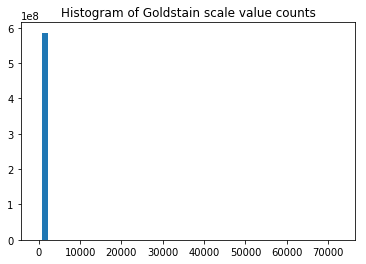

In [232]:
width = df['val'][1] 
plt.bar(df['val'], height=df['count'], width=width)
plt.title('Histogram of Goldstain scale value counts')
plt.show()

In [246]:
query = """
SELECT CEILING(NumMentions / (100 / 50)) * CEILING((100 / 50)) AS val, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE NumMentions < 100
GROUP BY val
ORDER BY val
"""
df = get_result_dataframe(query)

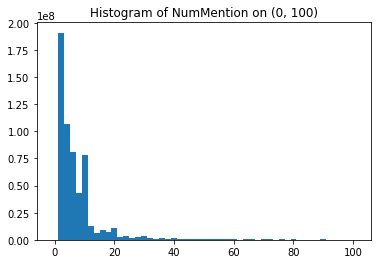

In [247]:
width = df['val'][1] 
plt.bar(df['val'], height=df['count'], width=width)
plt.title('Histogram of NumMention on (0, 100)')
plt.show()

### NumSources

In [250]:
query = """
SELECT CEILING(NumSources / (50 / 50)) * CEILING((50 / 50)) AS val, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE NumSources < 50
GROUP BY val
ORDER BY val
"""
df = get_result_dataframe(query)

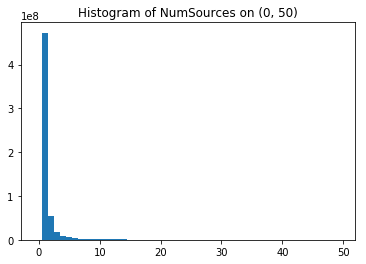

In [252]:
width = df['val'][1] 
plt.bar(df['val'], height=df['count'], width=width)
plt.title('Histogram of NumSources on (0, 50)')
plt.show()

### NumArticles

In [257]:
query = """
SELECT "all" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
UNION ALL
SELECT "equal" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE NumArticles = NumMentions
UNION ALL
SELECT "less or equal" AS cat, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE NumArticles <= NumMentions
UNION ALL
SELECT "corr" AS cat, CORR(NumArticles, NumMentions)
FROM `gdelt-bq.full.events`
"""
df = get_result_dataframe(query, index_col_name='cat')

In [258]:
print(round(100.0 * df.loc['equal'] / df.loc['all'], 2))
print(round(100.0 * df.loc['less or equal'] / df.loc['all'], 2))
print(round(df.loc['corr'],4))

94.91
100.0
0.9906


In [259]:
query = """
SELECT CEILING(NumArticles / (100 / 50)) * CEILING((100 / 50)) AS val, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE NumArticles < 100
GROUP BY val
ORDER BY val
"""
df = get_result_dataframe(query)

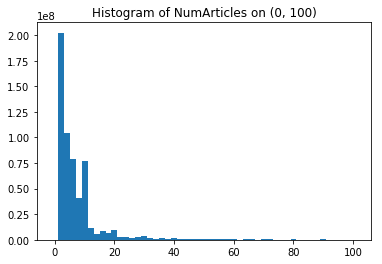

In [260]:
width = df['val'][1] 
plt.bar(df['val'], height=df['count'], width=width)
plt.title('Histogram of NumArticles on (0, 100)')
plt.show()

### AvgTone

In [261]:
query = """
SELECT CEILING(AvgTone / (10 / 25)) * CEILING((10 / 25)) AS val, COUNT(*) AS count
FROM `gdelt-bq.full.events`
WHERE AvgTone <= 10
AND AvgTone >= -10
GROUP BY val
ORDER BY val
"""
df = get_result_dataframe(query)

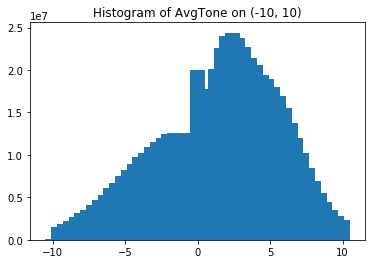

In [267]:
width = 1 
plt.bar(df['val'], height=df['count'], width=width)
plt.title('Histogram of AvgTone on (-10, 10)')
plt.show()

### Actor1Geo_Type/Actor2Geo_Type/ActionGeo_Type 

In [5]:
query = """
SELECT "a1_a2_el" AS index, count(*) AS count 
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode IS NOT NULL
AND Actor2Geo_CountryCode IS NOT NULL
AND ActionGeo_CountryCode IS NOT NULL
UNION ALL
SELECT "a1_a2" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode IS NOT NULL
AND Actor2Geo_CountryCode IS NOT NULL
AND ActionGeo_CountryCode IS NULL
UNION ALL
SELECT "a1_el" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode IS NOT NULL
AND Actor2Geo_CountryCode IS NULL
AND ActionGeo_CountryCode IS NOT NULL
UNION ALL
SELECT "a2_el" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode IS NULL
AND Actor2Geo_CountryCode IS NOT NULL
AND ActionGeo_CountryCode IS NOT NULL
UNION ALL
SELECT "a1" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode IS NOT NULL
AND Actor2Geo_CountryCode IS NULL
AND ActionGeo_CountryCode IS NULL
UNION ALL
SELECT "a2" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode IS NULL
AND Actor2Geo_CountryCode IS NOT NULL
AND ActionGeo_CountryCode IS NULL
UNION ALL
SELECT "el" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode IS NULL
AND Actor2Geo_CountryCode IS NULL
AND ActionGeo_CountryCode IS NOT NULL
"""
df = get_result_dataframe(query, index_col_name='index')

In [6]:
df

,count
index,
el,0
a1_a2_el,236952598
a2_el,34940051
a1,0
a1_el,99998348
a1_a2,0
a2,0


In [9]:
total = df['count'].sum()
print(round(100.0 * df.loc['a1_a2_el'] / total, 2))
print(round(100.0 * df.loc['a1_el'] / total, 2))
print(round(100.0 * df.loc['a2_el'] / total, 2))

63.72
26.89
9.4


In [15]:
query = """
SELECT Actor1Geo_Type AS type, count(*) AS count 
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_Type IS NOT NULL
GROUP BY Actor1Geo_Type
"""
df1 = get_result_dataframe(query)
query = """
SELECT Actor2Geo_Type AS type, count(*) AS count 
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor2Geo_Type IS NOT NULL
GROUP BY Actor2Geo_Type
"""
df2 = get_result_dataframe(query)
query = """
SELECT ActionGeo_Type AS type, count(*) AS count 
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND ActionGeo_Type IS NOT NULL
GROUP BY ActionGeo_Type
"""
df3 = get_result_dataframe(query)

In [16]:
df1['part'] = 100.0 * df1['count'] / df1['count'].sum()
df2['part'] = 100.0 * df2['count'] / df2['count'].sum()
df3['part'] = 100.0 * df3['count'] / df3['count'].sum()

In [22]:
type_name_maping = pd.Series(
    ['UNKNOWN', 'COUNTRY', 'USSTATE', 'USCITY', 'WORLDCITY', 'WORLDSTATE'],
    index=range(6)
)
df1['type_name'] = df1['type'].map(type_name_maping)
df2['type_name'] = df2['type'].map(type_name_maping)
df3['type_name'] = df3['type'].map(type_name_maping)
df1.sort_values('type', inplace=True)
df2.sort_values('type', inplace=True)
df3.sort_values('type', inplace=True)

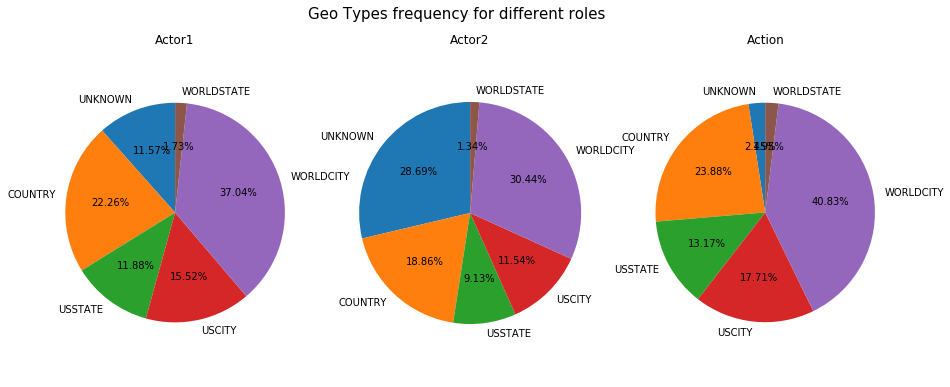

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
ax1.pie(df1['part'], labels=df1['type_name'], autopct='%1.2f%%', startangle=90)
ax1.axis('equal')
ax1.set_title('Actor1')
ax2.pie(df2['part'], labels=df2['type_name'], autopct='%1.2f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('Actor2')
ax3.pie(df3['part'], labels=df3['type_name'], autopct='%1.2f%%', startangle=90)
ax3.axis('equal')
ax3.set_title('Action')
fig.suptitle('Geo Types frequency for different roles', fontsize=15)
plt.show()

### Actor1Geo_CountryCode/Actor2Geo_CountryCode/ActionGeo_CountryCode

In [114]:
query = """
SELECT Actor1Geo_CountryCode AS type, count(*) AS count 
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode IS NOT NULL
GROUP BY Actor1Geo_CountryCode
"""
df1 = get_result_dataframe(query)
query = """
SELECT Actor2Geo_CountryCode AS type, count(*) AS count 
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor2Geo_CountryCode IS NOT NULL
GROUP BY Actor2Geo_CountryCode
"""
df2 = get_result_dataframe(query)
query = """
SELECT ActionGeo_CountryCode AS type, count(*) AS count 
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND ActionGeo_CountryCode IS NOT NULL
GROUP BY ActionGeo_CountryCode
"""
df3 = get_result_dataframe(query)

end loading
end loading
end loading


In [116]:
fips_iso_mapping = pd.read_csv('fips-iso-country.csv').groupby('FIPS')['ISO'].first()

In [142]:
dfs = []
for role, df in zip(['a1', 'a2', 'el'], [df1, df2, df3]):
    df['country_iso'] = df['type'].map(fips_iso_mapping)
    df = df.dropna()
    df = df.rename({'count': 'count_{}'.format(role)}, axis=1)
    dfs.append(df.groupby('country_iso')[['count_{}'.format(role)]].first())
    
df = pd.concat(dfs, axis=1).reset_index()

In [150]:
for col_name in ['count_a1', 'count_a2', 'count_el']:
    df[col_name] = np.log(df[col_name])

In [192]:
import plotly_express as px

target_col_name = 'count_el'

fig = px.choropleth(
    df,
    locations='country_iso',
    locationmode='ISO-3',
    color=target_col_name,
    labels={target_col_name: 'Log of event count'},
    color_continuous_scale=px.colors.cmocean.oxy,
    title="Log of event count by country as Actor 2"
)
fig

### Actor1Geo_Lat/Actor1Geo_Long

In [110]:
role = 'Actor1'
# role = 'Actor2'
# role = 'Action'

query = """
SELECT ROUND({role}Geo_Lat) AS lat, ROUND({role}Geo_Long) AS lon, count(*) AS count 
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND {role}Geo_Lat IS NOT NULL
AND {role}Geo_Long IS NOT NULL
GROUP BY lat, lon
""".format(role=role)
df = get_result_dataframe(query)

end loading


In [111]:
data = df[['lat', 'lon', 'count']].values

In [112]:
import folium
import folium.plugins as plugins

m = folium.Map(
    location=[45, 3],
    tiles='stamentoner',
    control_scale=True,
    zoom_start=2,
)

hm = plugins.HeatMap(
    data=data,
    radius=6,
    min_opacity=0.1,
    blur=9,
    max_val=70.
)
hm.add_to(m)
m.render()
with open('{role}_map.html'.format(role=role), 'w') as dest:
    dest.write(m._repr_html_().replace('"', "'"))


In [113]:
!cutycapt --url=file://$(pwd)/"$role"_map.html --out="$role"_map.png \
    --min-width=1800 --min-height=1000 --delay=1000